SSL pipeline (Barlow-Twin) using the geometric embeddings

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import psutil

In [2]:
import glob
import h5py
import random

#from keras.layers.merge import add
import matplotlib.pyplot as plt
import os
import scipy

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, Tensor
import pickle

In [4]:
from CoRE_2019.MOFormer_modded.transformer import Transformer, TransformerRegressor
from CoRE_2019.MOFormer_modded.dataset_modded import MOF_ID_Dataset
from CoRE_2019.MOFormer_modded.tokenizer.mof_tokenizer import MOFTokenizer
import csv
import yaml
from CoRE_2019.MOFormer_modded.model.utils import *

/home/sartaaj/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
tokenizer = MOFTokenizer("CoRE_2019/MOFormer_modded/tokenizer/vocab_full.txt")
config = yaml.load(open("CoRE_2019/MOFormer_modded/config_ft_transformer.yaml", "r"), Loader=yaml.FullLoader)
config['dataloader']['randomSeed'] = 0

if torch.cuda.is_available() and config['gpu'] != 'cpu':
    device = config['gpu']
    torch.cuda.set_device(device)
    config['cuda'] = True

else:
    device = 'cpu'
    config['cuda'] = False
print("Running on:", device)

Running on: cuda:0


In [26]:
from CoRE_2019.MOFormer_modded.transformer import PositionalEncoding
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

# the XRD and SMILES transformers (main model)
batch_size = 64
embed_size = 512

class TransformerXRD(nn.Module):
    def __init__(self, input_features=8192, seq_length=batch_size, transformer_heads=8, transformer_ff_dim=512, mlp_hidden_dim=256):
        super(TransformerXRD, self).__init__()
        
        # Project input features to sequence length dimension
        self.input_proj = nn.Linear(input_features, seq_length)
        
        # Define a single Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=seq_length, nhead=transformer_heads, dim_feedforward=transformer_ff_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
    def forward(self, x):
        # Project input features to sequence length dimension
        x_proj = self.input_proj(x)
        x_proj = x_proj.transpose(0, 1)
        
        # Pass through the Transformer encoder
        transformer_output = self.transformer_encoder(x_proj)
        
        # Revert to the original format (N, S) for the MLP
        transformer_output = transformer_output.transpose(0, 1)
        
        # Squeeze the output to remove the extra dimension if the output dimension is 1 -> else, consider alternative for multi-output regression tasks; maybe make conditional?
        return transformer_output

class Transformer(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.token_encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model

        self.init_weights()

    def init_weights(self) -> None:
        # initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        nn.init.xavier_normal_(self.token_encoder.weight)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.token_encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, 0:1, :] #this was added in by me

        return output.squeeze(dim = 1) #this was added in by me
        #return output

transformer_SMILES = Transformer(**config['Transformer'])
transformer_XRD = TransformerXRD()

class UnifiedTransformer(nn.Module):
    def __init__(self, config, input_features=8192, seq_length=batch_size, transformer_heads=8, transformer_ff_dim=512, mlp_hidden_dim=256):
        super(UnifiedTransformer, self).__init__()
        
        # Initialize Transformer1 with its parameters
        self.transformer1 = Transformer(**config['Transformer'])
        
        # Initialize Transformer2 components
        self.transformer2 = TransformerXRD(input_features, seq_length, transformer_heads, transformer_ff_dim, mlp_hidden_dim)

        #projector
        self.proj = nn.Sequential(
            nn.Linear(576, mlp_hidden_dim), #used to be mlp_hidden_dim here instead of 576 (output size)
            nn.Softplus(),
            nn.Linear(mlp_hidden_dim, embed_size) #used to be mlp_hidden_dim here instead of 576 (input size)
        )
                
    def forward(self, xrd, smiles):
        transformer1_output = self.transformer1(smiles) #gets output from SMILES transformer -> shape of (batchSize, 512, 512)
        transformer2_output = self.transformer2(xrd) #gets output from XRD transformer -> shape of (batchSize, seq_len)

        concatenated_tensor_corrected = torch.cat((transformer1_output, transformer2_output), dim=1)
        output = self.proj(concatenated_tensor_corrected)
        
        return output

/home/sartaaj/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [27]:
batch_size = 64
class TransformerGeo(nn.Module):
    """
    Returns embedding for geometric descriptors
    """
    def __init__(self, input_features=15, seq_length=batch_size, transformer_heads=8, transformer_ff_dim=512, mlp_hidden_dim=256):
        super(TransformerGeo, self).__init__()
        self.input_proj = nn.Linear(input_features, seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=seq_length, nhead=transformer_heads, dim_feedforward=transformer_ff_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.proj = nn.Sequential(
            nn.Linear(64, mlp_hidden_dim),
            nn.Softplus(),
            nn.Linear(mlp_hidden_dim, embed_size)
        )

    def forward(self, x):
        # Project input features to sequence length dimension
        x_proj = self.input_proj(x)
        x_proj = x_proj.transpose(0, 1)

        transformer_output = self.transformer_encoder(x_proj)
        transformer_output = transformer_output.transpose(0, 1)

        proj_out = self.proj(transformer_output)
        return proj_out

In [28]:
with open('SSL/sets/ssl_geo.pickle', 'rb') as handle:
    ssl_geo = pickle.load(handle)

with open('SSL/sets/ssl_xrd.pickle', 'rb') as handle:
    ssl_xrd = pickle.load(handle)

with open('SSL/sets/ssl_smiles.pickle', 'rb') as handle:
    ssl_smiles = pickle.load(handle)

In [29]:
data_size = len(ssl_xrd) #should give 8.5k entries for CoRE-2019
print(f'Full pretraining set size is {data_size}')
split_ratio = 0.85 #train set %
train_size = int(split_ratio * data_size)

ssl_xrd_train, ssl_smiles_train, ssl_geo_train = ssl_xrd[:train_size], ssl_smiles[:train_size], ssl_geo[:train_size]
ssl_xrd_val, ssl_smiles_val, ssl_geo_val = ssl_xrd[train_size-1::], ssl_smiles[train_size-1::], ssl_geo[train_size-1::]

Full pretraining set size is 133


In [30]:
ssl_geo_val.shape

(21, 64, 15)

In [31]:
model = UnifiedTransformer(config=config).to(device)
model_g = TransformerGeo().to(device)

In [32]:
from SSL.barlow_twins import BarlowTwinsLoss

loss = BarlowTwinsLoss(device = device, batch_size = 64, embed_size = embed_size, lambd = 0.0051) #same parameters as in moformer

learning_rate = 0.00001
optimizer_g = optim.Adam(model_g.parameters(), lr = learning_rate)
optimizer_t = optim.Adam(model.parameters(), lr = learning_rate)

In [33]:
config_m = yaml.load(open("CoRE_2019/MOFormer_modded/config_multiview.yaml", "r"), Loader=yaml.FullLoader)
optimizer = torch.optim.Adam(list(model.parameters()) + list(model_g.parameters()), lr = config_m['optim']['init_lr'], weight_decay=eval(config_m['optim']['weight_decay']))

In [34]:
#now, test for 100 epoch?

num_epoch = 100
loss_history = []
val_history = []
n_iter = 0
valid_n_iter = 0
best_valid_loss = np.inf
norm = False #should embeddings be normalized? in crystal-twin, they don't but for barlow-twin, it's in the algorithm

for epoch in range(num_epoch):
    model_g.train()
    model.train()

    print(f'Epoch : {epoch + 1}')
    loss_ensemble = []
    for bn, (geo, xrd, smiles) in enumerate(zip(ssl_geo_train, ssl_xrd_train, ssl_smiles_train)):
        geo = torch.tensor(geo, dtype = torch.float).to(device)
        
        xrd = torch.tensor(xrd, dtype = torch.float).to(device)
        smiles = torch.from_numpy(smiles).to(device)
        
        z_a = model_g(geo) #embedding from transformer geo
        z_b = model(xrd, smiles) #embedding from concat. model

        if norm == True:
            z_a_norm = (z_a - torch.mean(z_a, axis = 0))/torch.std(z_a, axis = 0)
            z_b_norm = (z_b - torch.mean(z_b, axis = 0))/torch.std(z_b, axis = 0)
        
        else:
            z_a_norm = z_a
            z_b_norm = z_b

        loss_calc = loss(z_a_norm, z_b_norm)
        loss_ensemble.append(loss_calc.item())

        #optimizer_g.zero_grad()
        #optimizer_t.zero_grad()
        optimizer.zero_grad()

        loss_calc.backward()

        #optimizer_g.step()
        #optimizer_t.step()
        optimizer.step()
    
    torch.cuda.empty_cache()
    val_ensemble = []

    with torch.no_grad():
        model.eval()
        model_g.eval()
        for bn, (geo, xrd, smiles) in enumerate(zip(ssl_geo_val, ssl_xrd_val, ssl_smiles_val)):
            geo = torch.tensor(geo, dtype = torch.float).to(device)
            
            xrd = torch.tensor(xrd, dtype = torch.float).to(device)
            smiles = torch.from_numpy(smiles).to(device)

            z_a = model_g(geo)
            z_b = model(xrd, smiles)

            if norm == True:
                z_a_norm = (z_a - torch.mean(z_a, axis = 0))/torch.std(z_a, axis = 0)
                z_b_norm = (z_b - torch.mean(z_b, axis = 0))/torch.std(z_b, axis = 0)
            else:
                z_a_norm = z_a
                z_b_norm = z_b
            
            valid_loss = loss(z_a_norm, z_b_norm)
            val_ensemble.append(valid_loss.item())

        val_history.append(np.mean(val_ensemble))
        if np.mean(val_ensemble) < best_valid_loss:
            best_valid_loss = np.mean(val_ensemble)
            
            #save the models here?
            torch.save(model.state_dict(), os.path.join('SSL/pretrained/geometric', 'model_t.pth'))
            torch.save(model_g.state_dict(), os.path.join('SSL/pretrained/geometric', 'model_g.pth'))

    
    loss_history.append(np.mean(loss_ensemble))
    print(f'Ensembled Loss : {loss_history[-1]}, Val. Ensembled Loss : {val_history[-1]}')
    print('###############################')

Epoch : 1
Ensembled Loss : 511.65875109107094, Val. Ensembled Loss : 467.5064188639323
###############################
Epoch : 2
Ensembled Loss : 424.88275065464256, Val. Ensembled Loss : 372.0450846354167
###############################
Epoch : 3
Ensembled Loss : 350.55145344691994, Val. Ensembled Loss : 331.88647024972096
###############################
Epoch : 4
Ensembled Loss : 323.8904832147919, Val. Ensembled Loss : 321.05251057942706
###############################
Epoch : 5
Ensembled Loss : 314.62334853990944, Val. Ensembled Loss : 316.0304042271205
###############################
Epoch : 6
Ensembled Loss : 309.51950991470204, Val. Ensembled Loss : 312.4289768763951
###############################
Epoch : 7
Ensembled Loss : 305.52835785182174, Val. Ensembled Loss : 309.33215186709447
###############################
Epoch : 8
Ensembled Loss : 302.39501034896983, Val. Ensembled Loss : 306.4493916829427
###############################
Epoch : 9
Ensembled Loss : 299.01593233631775,

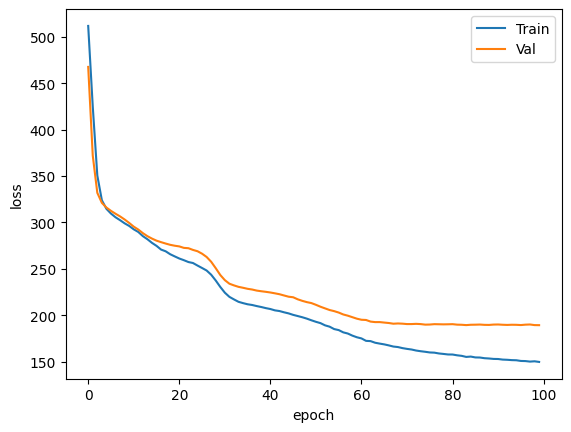

In [35]:
plt.plot(loss_history, label = 'Train')
plt.plot(val_history, label = 'Val')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(loc = 'upper right')
plt.savefig(os.path.join('SSL/figures/geo_pretrain', f'SSL_learning_curve_{num_epoch}_{norm}.png'))

In [ ]:
#not really learning - why? maybe compare to MOFormer and see how much their loss decreased by.
#edit: issue fixed, initially set learning rate -> 0.0051 but it was too high (must have gotten stuck in a local minima somewhere) - it is learning now.